# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pysra.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pysra.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pysra.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pysra.site.Profile(
    [
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pysra.site.Layer(pysra.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pysra.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pysra.variation.ToroThicknessVariation()
var_velocity = pysra.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pysra.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection(
    [
        pysra.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pysra.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pysra.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pysra.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pysra.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pysra.output.InitialVelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pysra.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

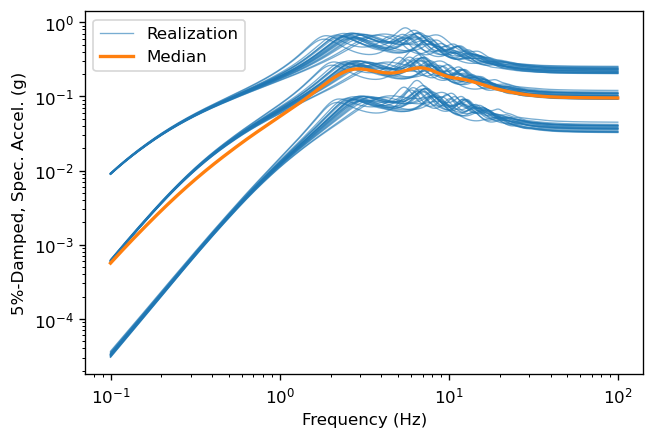

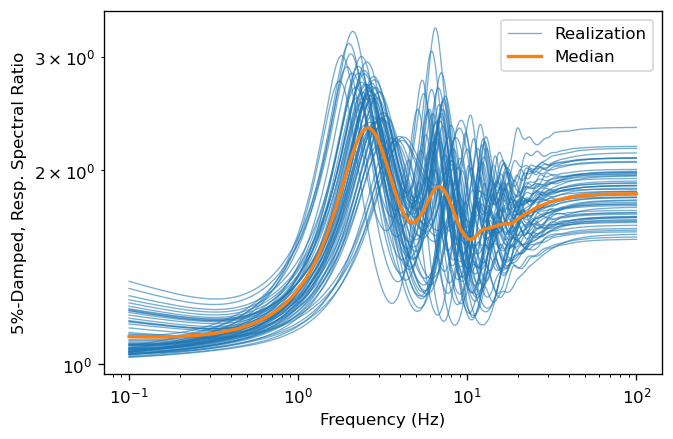

In [9]:
for o in outputs[:-1]:
    ax = o.plot(style="stats")

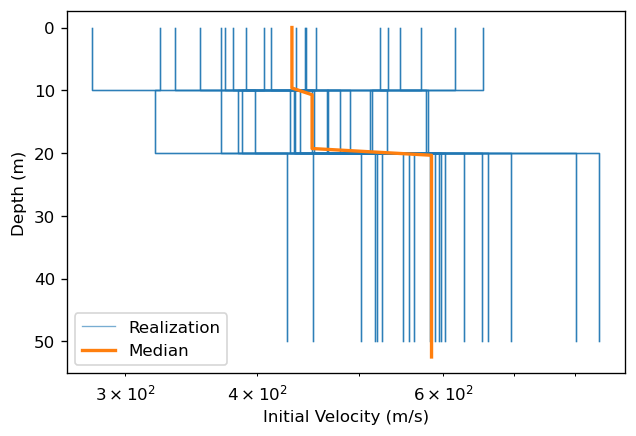

In [10]:
ax = outputs[-1].plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [12]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.112824  1.038489  1.023598  1.177306  1.059560  1.036686   
0.101394    1.112542  1.038480  1.023791  1.176697  1.059520  1.036974   
0.102807    1.112261  1.038475  1.023986  1.176089  1.059484  1.037265   
0.104240    1.111981  1.038473  1.024182  1.175484  1.059454  1.037560   
0.105693    1.111703  1.038475  1.024381  1.174881  1.059428  1.037857   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.967215  1.866101  1.815002  1.714994  1.663185  1.573122   
95.932095   1.967231  1.866104  1.815020  1.715061  1.663247  1.573197   
97.269336   1.967245  1.866107  1.815037  1.715127  1.663307  1.573270   
98.625218   1.967260  1.866110  1.815054  1.715190  1.663366  1.573340   
100.000000  1.967274  1.866112  1.815070  1.715251  1.663423  1.573408   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.243468  1.080479  1.050244  1.118486  ...  1.054677  1.161868   
0.101394    1.242556  1.080406  1.050627  1.118166  ...  1.055090  1.161370   
0.102807    1.241646  1.080339  1.051014  1.117847  ...  1.055508  1.160873   
0.104240    1.240740  1.080278  1.051405  1.117529  ...  1.055929  1.160378   
0.105693    1.239838  1.080222  1.051800  1.117213  ...  1.056355  1.159885   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.909654  1.830694  1.686505  1.717409  ...  1.957141  1.939615   
95.932095   1.909740  1.830781  1.686611  1.717473  ...  1.957260  1.939666   
97.269336   1.909825  1.830866  1.686714  1.717535  ...  1.957376  1.939715   
98.625218   1.909906  1.830948  1.686814  1.717596  ...  1.957488  1.939763   
100.000000  1.909985  1.831028  1.686911  1.717654  ...  1.957597  1.939809   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.055163  1.034224  1.167187  1.056340  1.034686  1.214146   
0.101394    1.055133  1.034495  1.166627  1.056305  1.034960  1.213420   
0.102807    1.055106  1.034769  1.166068  1.056274  1.035237  1.212697   
0.104240    1.055085  1.035046  1.165511  1.056248  1.035516  1.211977   
0.105693    1.055068  1.035325  1.164957  1.056227  1.035799  1.211259   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.852768  1.769835  1.687543  1.640439  1.560310  2.175677   
95.932095   1.852810  1.769894  1.687615  1.640503  1.560386  2.175744   
97.269336   1.852851  1.769950  1.687685  1.640566  1.560459  2.175808   
98.625218   1.852890  1.770005  1.687752  1.640626  1.560530  2.175871   
100.000000  1.852927  1.770058  1.687818  1.640685  1.560599  2.175931   

                                
                  m1        m2  
0.100000    1.072594  1.045797  
0.101394    1.072538  1.046150  
0.102807    1.072487  1.046506  
0.104240    1.072442  1.046866  
0.105693    1.072402  1.047230  
...              ...       ...  
94.613238   2.055386  1.921683  
95.932095   2.055449  1.921773  
97.269336   2.055511  1.921861  
98.625218   2.055571  1.921946  
100.000000  2.055629  1.922028  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [13]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.reset_index().melt(id_vars="freq")
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.112824
1,0.101394,p0,m0,1.112542
2,0.102807,p0,m0,1.112261
3,0.104240,p0,m0,1.111981
4,0.105693,p0,m0,1.111703
...,...,...,...,...
29995,94.613238,p19,m2,1.921683
29996,95.932095,p19,m2,1.921773
29997,97.269336,p19,m2,1.921861
29998,98.625218,p19,m2,1.921946


In [14]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.203182  0.048308
           m1      1.067997  0.016906
           m2      1.042325  0.010901
0.101394   m0      1.202476  0.048104
           m1      1.067945  0.016880
...                     ...       ...
98.625218  m1      1.848635  0.076773
           m2      1.729208  0.067429
100.000000 m0      1.937534  0.087242
           m1      1.848694  0.076775
           m2      1.729284  0.067429

[1500 rows x 2 columns]

In [15]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.048308  1.203182  0.016906  1.067997  0.010901  1.042325
0.101394    0.048104  1.202476  0.016880  1.067945  0.010974  1.042652
0.102807    0.047900  1.201772  0.016854  1.067897  0.011047  1.042982
0.104240    0.047696  1.201070  0.016829  1.067855  0.011122  1.043315
0.105693    0.047493  1.200371  0.016805  1.067818  0.011197  1.043652
...              ...       ...       ...       ...       ...       ...
94.613238   0.087244  1.937275  0.076768  1.848447  0.067430  1.728965
95.932095   0.087244  1.937343  0.076770  1.848512  0.067430  1.729049
97.269336   0.087243  1.937408  0.076772  1.848574  0.067429  1.729130
98.625218   0.087243  1.937472  0.076773  1.848635  0.067429  1.729208
100.000000  0.087242  1.937534  0.076775  1.848694  0.067429  1.729284

[500 rows x 6 columns]

Access the properties of each motion like:

In [16]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.048308,1.203182
0.101394,0.048104,1.202476
0.102807,0.047900,1.201772
0.104240,0.047696,1.201070
0.105693,0.047493,1.200371
...,...,...
94.613238,0.087244,1.937275
95.932095,0.087244,1.937343
97.269336,0.087243,1.937408


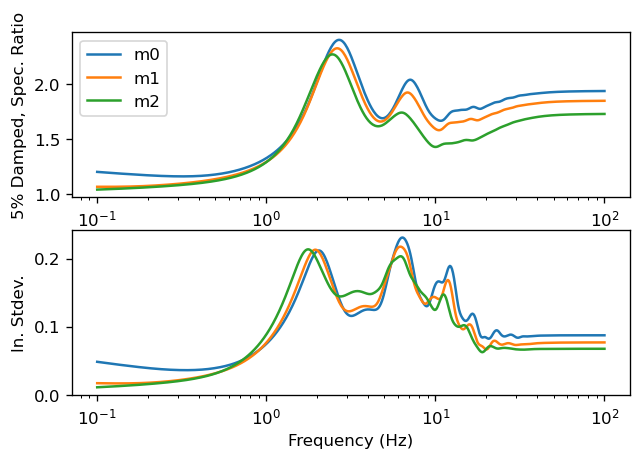

In [17]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.index, g[(name, key)], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;